# Adjusted Data Phase One, Function-based

import applicable libraries

In [32]:
%matplotlib inline

import matplotlib as mp

import pandas as pd

import numpy as np

import scipy as sp

import scipy.linalg as spl

import glob

import json

import urllib2

from datetime import datetime 

import matplotlib.pyplot as pl

import re

import obspy

from obspy.core import UTCDateTime

import geomagio

from geomagio.edge import EdgeFactory

#from geomagio.Algorithm import DeltaFAlgorithm

Set up edge factory

In [33]:
factory = EdgeFactory(host='137.227.224.97', port=2060)

Class used as a container for absolute $[ H, D, Z ]^T$, baseline $[ H, D, Z ]^T$,  and start times of absolute measurements

In [34]:
class Baselines:

    

    def __init__(self):

        self.absH = []

        self.absD = []

        self.absZ = []

        self.baseH = []

        self.baseD = []

        self.baseZ = []

        self.begin = []



        

Class containing absolutes ($[ X, Y, Z ]^T$) and ordinates ($[ h, e, z]^T$).  Conversion of coordinates happens in <pre>get_ord_abs_from_baselines</pre>

In [35]:
class AbsOrds:

    

    def __init__(self):

        self.ordp1 = []

        self.absp1 = []

Function that reads a json file output from the <pre>geomag-baseline-calculator</pre> webservice (currently requires login, url <pre>https://geohazards.usgs.gov/baselines/baseline_data.php?observatoryId=3&startTime=1419630615&endTime=1453326615</pre>

In [36]:
def get_baselines_from_file(filename):

    f = open(filename)

    json12 = f.read()

    parsed_json12 = json.loads(json12)

    f.close()

    bns = Baselines()

    for i1 in range(len(parsed_json12)):

        if ((parsed_json12[i1]['horizontal_intensity_valid'] == 'Y') & (parsed_json12[i1]['vertical_intensity_valid'] == 'Y') & (parsed_json12[i1]['declination_valid'] == 'Y')):

            if ((parsed_json12[i1]['absH'] !=  None) & (parsed_json12[i1]['absD'] != None) & (parsed_json12[i1]['absZ'] != None) & (parsed_json12[i1]['baseH'] != None) & (parsed_json12[i1]['baseD'] != None) & (parsed_json12[i1]['baseZ'] != None)):

                bns.absH.append(parsed_json12[i1]['absH'])

                bns.absD.append(parsed_json12[i1]['absD']*np.pi/180)

                bns.absZ.append(parsed_json12[i1]['absZ'])

                #bns.baseH.append(parsed_json12[i1]['baseH'])

                #alternate d undoing small angle approximation in web absolutes

                db1 = parsed_json12[i1]['baseD']*np.pi/180

                da1 = parsed_json12[i1]['absD']*np.pi/180

                do1 = da1 - db1

                do2 = np.arctan(do1)

                if (do2 >np.pi/2):

                    do2 = do2 - np.pi/2

                if (do2 < -np.pi/2):

                    do2 = do2 + np.pi/2

                db2 = da1 - do2

                bns.baseD.append(db2)

                #alternate h undoing small angle approximation in web absolutes

                hb1 = parsed_json12[i1]['baseH']

                ha1 = parsed_json12[i1]['absH']

                ho1 = ha1 - hb1

                ho2 = ho1/np.cos(do2)

                hb2 = ha1 - ho2

                bns.baseH.append(hb2)

                #bns.baseD.append(parsed_json12[i1]['baseD']*np.pi/180)

                bns.baseZ.append(parsed_json12[i1]['baseZ'])

                bns.begin.append(parsed_json12[i1]['begin'])

    return bns

Function that gets baselines between a given date pair

In [37]:
def get_bns_between_dates(a,b,baselines):

    d = next(idx for idx, value in enumerate(baselines.begin) if value > a)

    e = next(idx for idx, value in enumerate(baselines.begin) if value > b)

    baselines.absH = np.asarray(baselines.absH[d:e])

    baselines.absD = np.asarray(baselines.absD[d:e])

    baselines.absZ = np.asarray(baselines.absZ[d:e])

    baselines.baseH = np.asarray(baselines.baseH[d:e])

    baselines.baseD = np.asarray(baselines.baseD[d:e])

    baselines.baseZ = np.asarray(baselines.baseZ[d:e])

    baselines.begin = np.asarray(baselines.begin[d:e])

Function that removes baselines above and below one standard deviation from the mean

In [38]:
def remove_outlier_baselines(baselines):

    baseHstd = baselines.baseH.std()

    baseHave = baselines.baseH.mean()

    maskH = (abs(baselines.baseH - baseHave) < baseHstd)

    baseDstd = baselines.baseD.std()

    baseDave = baselines.baseD.mean()

    maskD = (abs(baselines.baseD - baseDave) < baseDstd)

    baseZstd = baselines.baseZ.std()

    baseZave = baselines.baseZ.mean()

    maskZ = (abs(baselines.baseZ - baseZave) < baseZstd)

    maskbase = maskH & maskD & maskZ

    baselines.absH = baselines.absH[maskbase]

    baselines.absD = baselines.absD[maskbase]

    baselines.absZ = baselines.absZ[maskbase]

    baselines.baseH = baselines.baseH[maskbase]

    baselines.baseD = baselines.baseD[maskbase]

    baselines.baseZ = baselines.baseZ[maskbase]

    baselines.begin = baselines.begin[maskbase]

Function that converts $[ H, D, Z ]^T$ in ordinate, absolute (absolute = ordinate + baseline) to $[ h, e, z ]^T$ and $[ X, Y, Z ]^T$

In [39]:
def get_ord_abs_from_baselines(baselines):

    absolutes_ordinates = AbsOrds()

    ordH = baselines.absH - baselines.baseH

    ordD = baselines.absD - baselines.baseD

    ordZ = baselines.absZ - baselines.baseZ

    ordh = ordH*np.cos(ordD)

    orde = ordH*np.sin(ordD)

    ordz = ordZ

    absh = baselines.absH*np.cos(baselines.absD)

    abse = baselines.absH*np.sin(baselines.absD)

    absz = baselines.absZ

    absolutes_ordinates.absp1 = np.vstack([absh,abse,absz])

    absolutes_ordinates.ordp1 = np.vstack([ordh,orde,ordz])

    return absolutes_ordinates

Function that computes the affine transform matrix from the absolutes using numpy's least squares function of the linear algebra library.  More robust than, but similar to the matrix multiplication method that would compute the 2-norm-minimizing solution $[M]$ of:
$$ \left[\begin{array}{cccc} X_1 & X_2 & \ldots & X_n \\ 
                          Y_1 & Y_2 & \ldots & Y_n \\
                          Z_1 & Z_2 & \ldots & Z_n \\
                          1   &  1  &  \ldots & 1 \end{array}\right] = [M] \left[ \begin{array}{cccc} h_1 & h_2 & \ldots & h_n \\ 
                          e_1 & e_2 & \ldots & e_n \\
                          z_1 & z_2 & \ldots & z_n \\
                          1   &  1  &  \ldots & 1 \end{array}\right] $$

In [40]:
def get_transform_from_abs_ords(abs_ords):

    tol = 1e-15
    
    ones = np.ones(abs_ords.ordp1[1].shape)

    ordp2 = np.vstack([abs_ords.ordp1,ones])

    absp2 = np.vstack([abs_ords.absp1,ones])

    M, res, rank, sigma = np.linalg.lstsq(ordp2.T,absp2.T)

    maskM = np.abs(M) > tol
    
    M = maskM * M
    
    return M.T, res, rank, sigma

Function that applies the first equation (matrix-multiplies $[M]$ by the array of $[ h, e, z, 1]^T$ vectors
in the previous markdown comment block)

In [41]:
def make_adjusted_from_transform_and_raw(M,raw):

    h = raw[0]

    hd = h.data

    e = raw[1]

    ed = e.data

    z = raw[2]

    zd = z.data

    raws = np.vstack([hd,ed,zd,np.ones(hd.shape)])

    adj = np.dot(M,raws)

    return adj

Function that saves the computed matrix, as well as the pier correction, in json format

In [42]:
 def save_state(filename, M, PC):
        """Save algorithm state to a file.
        File name is filename.
        """
        
        data = {
            'M11': M[0,0],
            'M12': M[0,1],
            'M13': M[0,2],
            'M14': M[0,3],
            'M21': M[1,0],
            'M22': M[1,1],
            'M23': M[1,2],
            'M24': M[1,3],
            'M31': M[2,0],
            'M32': M[2,1],
            'M33': M[2,2],
            'M34': M[2,3],
            'M41': M[3,0],
            'M42': M[3,1],
            'M43': M[3,2],
            'M44': M[3,3],
            'PC':  PC
        }
        with open(filename, 'w') as f:
            f.write(json.dumps(data))

## Example Problem Demonstrating the Adjusted Data Algorithm

Example function.  x1 takes the place of time, x2, y2, and z2 take the place of magnetic measurements in the three axes.  Chosen to show how different affine linear transformations effect orientation, location, stretch, etc.

In [43]:
x1 = np.linspace(0,np.pi, 5000)

x2 = (2*x1 - np.pi)/np.pi

In [44]:
y2 = np.sqrt(1 - x2**2)*np.cos(24*x1)

z2 = np.sqrt(1 - x2**2)*np.sin(24*x1)

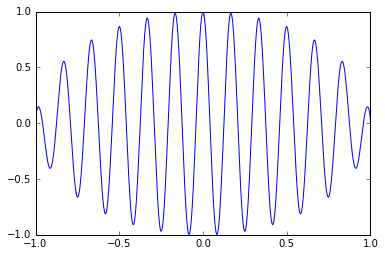

In [45]:
pl.plot(x2,y2)

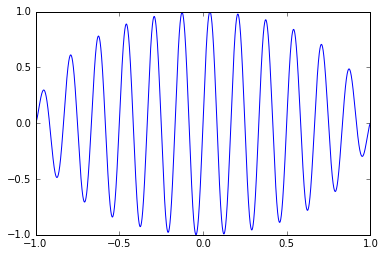

In [46]:
pl.plot(x2,z2)

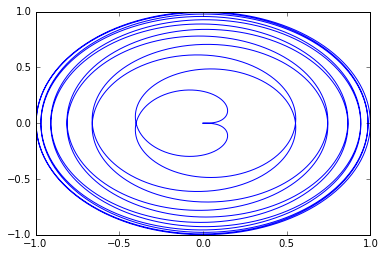

In [47]:
pl.plot(y2,z2)

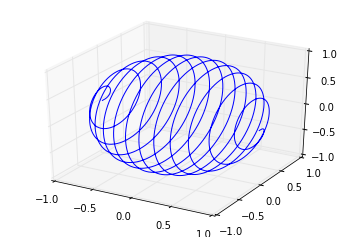

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot(x2,y2,z2)

Function to rotate axes.  Makes a rotation matrix $M_{rot}$

In [49]:
variations2 = np.vstack([x2,y2,z2])
variations2e = np.vstack([variations2,np.ones(np.shape(x2))])

def make_axis_rotation_matrix(direction, angle):
     """
     Create a rotation matrix corresponding to the rotation around a general
     axis by a specified angle.

     R = dd^T + cos(a) (I - dd^T) + sin(a) skew(d)

     Parameters:

         angle : float a
         direction : array d
     """
     d = np.array(direction, dtype=np.float64)
     d /= np.linalg.norm(d)

     eye = np.eye(3, dtype=np.float64)
     ddt = np.outer(d, d)
     skew = np.array([[    0,  d[2],  -d[1]],
                      [-d[2],     0,  d[0]],
                      [d[1], -d[0],    0]], dtype=np.float64)

     mtx = ddt + np.cos(angle) * (eye - ddt) + np.sin(angle) * skew
     return mtx
    
Mrot = make_axis_rotation_matrix(np.array([1,1,1]),45*np.pi/180)
Mrot

array([[ 0.80473785,  0.50587936, -0.31061722],
       [-0.31061722,  0.80473785,  0.50587936],
       [ 0.50587936, -0.31061722,  0.80473785]])

Matrix to change the scale (stretch) of the data (think scale value, but nanotesla to nanotesla scale).  An entry of 1.5 means the sensor reports 1.5 nT for a field value of 1 nT  $M_{scale}$

In [50]:
Mscale = np.array([[1.5, 0, 0], [0, 0.95, 0], [0, 0, 1.2]])
Mscale

array([[ 1.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.95,  0.  ],
       [ 0.  ,  0.  ,  1.2 ]])

Translation vector, or offset.  This says that at a field of 0 nT, the sensor reports a non-zero value of the field strength.  $V_{trans}$

In [51]:
Vtranslate = np.array([[5],[10],[7]])
Vtranslate

array([[ 5],
       [10],
       [ 7]])

The final matrix combines these operations.  Here I've taken the shortcut to put the translation in, and multiply the 3x3 matrices $M_{3x3} = M_{rot}*M_{scale}$, then this is augmented by $V_{trans}$ on the right, and $[0, 0, 0, 1]$ on the bottom.  this is the form of an affine transformation matrix in 3 dimensions.

In [52]:
Maugmented = np.hstack([np.dot(Mscale,Mrot), Vtranslate])
Maugmented

array([[  1.20710678,   0.75881905,  -0.46592583,   5.        ],
       [ -0.29508636,   0.76450096,   0.4805854 ,  10.        ],
       [  0.60705524,  -0.37274066,   0.96568542,   7.        ]])

In [53]:
Maffine = np.vstack([Maugmented, np.array([0,0,0,1])])
Maffine

array([[  1.20710678,   0.75881905,  -0.46592583,   5.        ],
       [ -0.29508636,   0.76450096,   0.4805854 ,  10.        ],
       [  0.60705524,  -0.37274066,   0.96568542,   7.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

Here I apply the transformation the sensor might (the rotation is a bit much but it's illustrative).

In [54]:
hez2 = np.dot(Maffine,variations2e)

Below is a visual representation of the true field values (blue) and the sensor's field values (red)

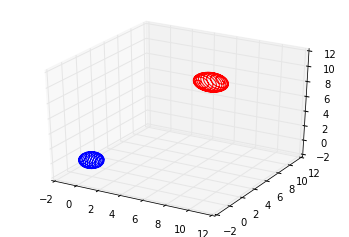

In [55]:
fig2 = pl.figure()

ax2 = fig2.add_subplot(111,projection='3d')
ax2.set_xlim3d(-2,12)
ax2.set_ylim3d(-2,12)
ax2.set_zlim3d(-2,12)
ax2.plot(hez2[0,:],hez2[1,:],hez2[2,:],'r')
ax2.hold(True)
ax2.plot(x2,y2,z2,'b')
pl.savefig('hezftrial.png')

In [56]:
hez2[0,0:5]

array([ 3.79289322,  3.8146376 ,  3.82363296,  3.83043869,  3.83607063])

Here is the sensor data viewed from the true axes:

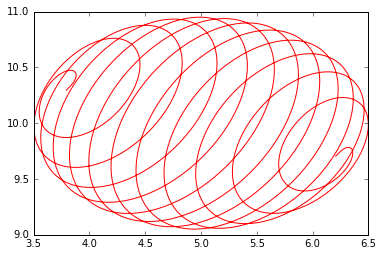

In [57]:
pl.plot(hez2[0,:],hez2[1,:],'r')

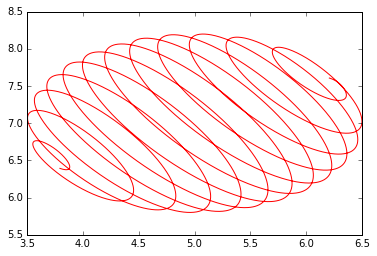

In [58]:
pl.plot(hez2[0,:],hez2[2,:],'r')

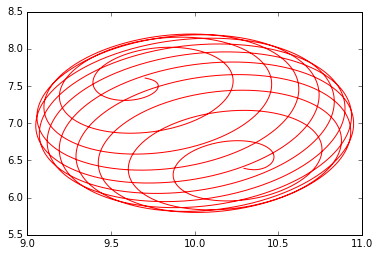

In [59]:
pl.plot(hez2[1,:],hez2[2,:],'r')

Here the time series are shown, true data in blue, sensor data in red

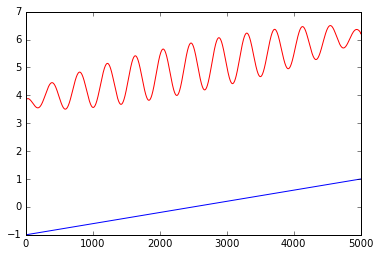

In [60]:
pl.plot(hez2[0],'r')
pl.plot(x2,'b')

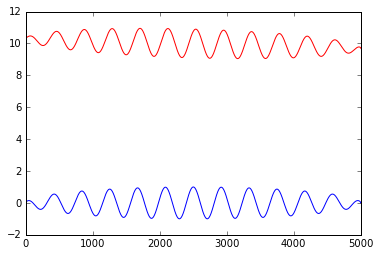

In [61]:
pl.plot(hez2[1],'r')
pl.plot(y2,'b')

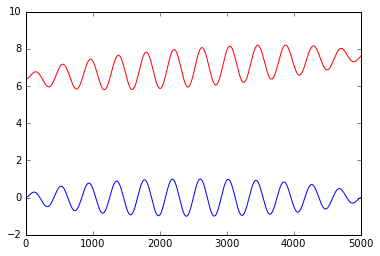

In [62]:
pl.plot(hez2[2],'r')
pl.plot(z2,'b')

Here we are making the absolutes and ordinates by sub-sampling, similar to taking absolutes

In [63]:
#ex_bns  = Baselines()
#ex_bns.baseH = x2[:250:] - hez2[0,:250:]
#ex_bns.baseD = y2[:250:]
ex_abs_ord = AbsOrds()
ex_abs_ord.ordp1 = hez2[0:3,::250]
ex_abs_ord.absp1 = variations2e[0:3,::250]
ex_abs_ord.absp1
irange = np.linspace(0,4999,5000)[::250]

Below we make the transform from the ordinates and absolutes

In [64]:
Mex, resex, rankx, sigx = get_transform_from_abs_ords(ex_abs_ord)

In [65]:
Mex

array([[ 0.5364919 , -0.32696549,  0.42156614, -2.36376755],
       [ 0.33725291,  0.84709248, -0.25884768, -8.34525556],
       [-0.20707815,  0.53250459,  0.67061488, -8.98395935],
       [ 0.        ,  0.        , -0.        ,  1.        ]])

This transform should be close to the inverse of the example scaling, translating and rotating we did earlier.  Changing to orthogonal coordinates is also a linear affine transformation, even though we did not include it in our example.

In [66]:
Mexi = np.linalg.inv(Mex)
Mexi

array([[ 1.20710678,  0.75881905, -0.46592583,  5.        ],
       [-0.29508636,  0.76450096,  0.4805854 , 10.        ],
       [ 0.60705524, -0.37274066,  0.96568542,  7.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Here we can see that to within floating point math error, we have essentially un-done the transformation the sensor applies to the field

In [67]:
Mdifference = Mexi - Maffine
Mdifference

array([[ -1.33226763e-15,   1.22124533e-15,  -1.05471187e-15,
         -8.88178420e-16],
       [ -1.27675648e-15,   7.77156117e-16,  -4.44089210e-16,
         -1.77635684e-15],
       [  1.11022302e-16,   1.22124533e-15,  -5.55111512e-16,
         -3.55271368e-15],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         -2.22044605e-16]])

Here we apply the inverse transform we found to make adjusted data from the sensor data

In [68]:
h2Trace = obspy.Trace(data=hez2[0])
e2Trace = obspy.Trace(data=hez2[1])
z2Trace = obspy.Trace(data=hez2[2])
hez2Stream = obspy.Stream(traces=(h2Trace,e2Trace,z2Trace))
adj_ex = make_adjusted_from_transform_and_raw(Mex,hez2Stream)

Here we visualise the absolutes (blue), ordinates(red), and adjusted data (black).  absolutes are taken at the times shown by stars in the plot

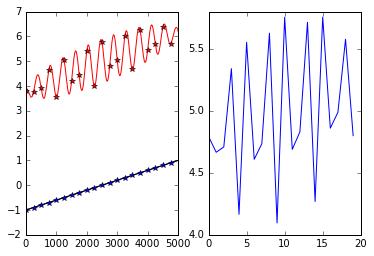

In [69]:
pl.subplot(1,2,1)
pl.plot(hez2[0],'r')
pl.plot(irange, ex_abs_ord.ordp1[0],'r*')
pl.plot(x2,'b')
pl.plot(adj_ex[0],'k')
pl.plot(irange,ex_abs_ord.absp1[0],'b*')
pl.subplot(1,2,2)
pl.plot(ex_abs_ord.ordp1[0] - ex_abs_ord.absp1[0])

Here we plot the error in the x component

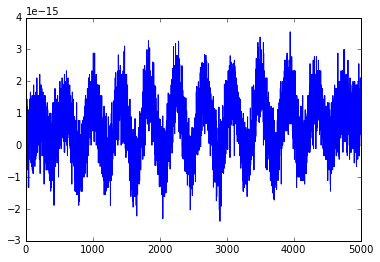

In [70]:
pl.plot(adj_ex[0] - x2)

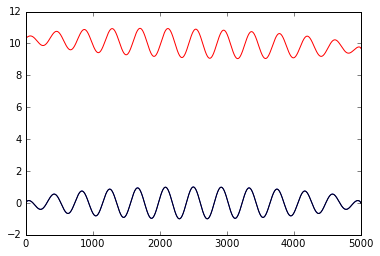

In [71]:
pl.plot(hez2[1],'r')
pl.plot(y2,'b')
pl.plot(adj_ex[1],'k')

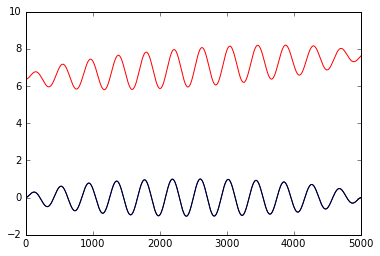

In [72]:
pl.plot(hez2[2],'r')
pl.plot(z2,'b')
pl.plot(adj_ex[2],'k')

Here we show the absolute error as a function of how many absolutes are taken

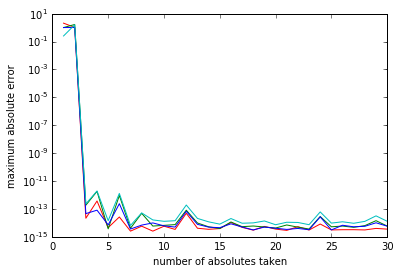

In [76]:
a = np.arange(30)
max_error_x = np.ones_like(np.float64(a))
max_error_y = np.ones_like(np.float64(a))
max_error_z = np.ones_like(np.float64(a))
max_error_fc = np.ones_like(np.float64(a))

for n_abs in a:
    skip = 5000/(n_abs + 1)
    ex_abs_ord = AbsOrds()
    ex_abs_ord.ordp1 = hez2[0:3,::skip]
    ex_abs_ord.absp1 = variations2e[0:3,::skip]
    ex_abs_ord.absp1
    irange = np.linspace(0,4999,5000)[::skip]
    Mex, resex, rankx, sigx = get_transform_from_abs_ords(ex_abs_ord)
    adj_ex = make_adjusted_from_transform_and_raw(Mex,hez2Stream)
    max_error_x[n_abs] = np.max(np.abs(np.float64(adj_ex[0] - x2)))
    max_error_y[n_abs] = np.max(np.abs(np.float64(adj_ex[1] - y2)))
    max_error_z[n_abs] = np.max(np.abs(np.float64(adj_ex[2] - z2)))
    max_error_fc[n_abs] = np.max(np.abs(np.float64(adj_ex[0]**2 + adj_ex[1]**2 + adj_ex[2]**2 - x2**2 - y2**2 - z2**2)))

#pl.ylim(0,0.00002)
#pl.xlim(3,20)
pl.semilogy(a+1, max_error_x, 'r', a+1, max_error_y, 'g', a+1, max_error_z, 'b', a+1, max_error_fc, 'c')
pl.xlabel('number of absolutes taken')
pl.ylabel('maximum absolute error')

In [77]:
max_error_x

array([  2.06799438e+00,   1.02560749e+00,   2.14203655e-14,
         3.68281794e-13,   4.55191440e-15,   2.63261635e-14,
         2.55351296e-15,   5.77315973e-15,   2.55351296e-15,
         5.74540415e-15,   3.38618023e-15,   4.86208296e-14,
         4.10782519e-15,   3.44169138e-15,   3.88578059e-15,
         1.06581410e-14,   4.77395901e-15,   2.99760217e-15,
         5.55111512e-15,   3.55271368e-15,   2.88657986e-15,
         5.32907052e-15,   3.05831749e-15,   8.24340596e-15,
         3.10862447e-15,   3.21964677e-15,   3.23352456e-15,
         3.10862447e-15,   3.99680289e-15,   3.55271368e-15])

$$\alpha = 1$$

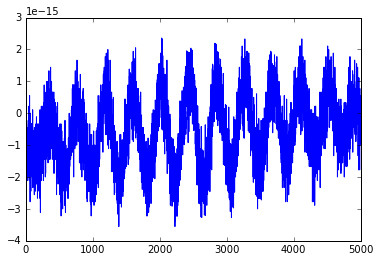

In [78]:
pl.plot(adj_ex[0] - x2)

In [79]:
np.max(np.abs(adj_ex[0]-x2))

3.5527136788005009e-15

Here the matrices are calculated for different observatories.  One thing we have not done in phase one is correct for the effect of temperature on scale and offset (part of the physics of fluxgate magnetometers).

In [80]:
bou_bns = get_baselines_from_file('/users/aclaycomb/Documents/boujson12.txt')

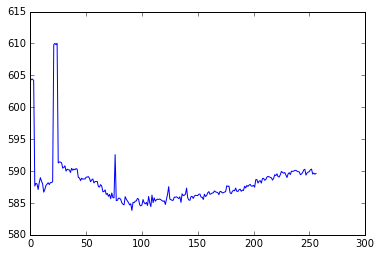

In [81]:
pl.plot(bou_bns.baseZ)

In [82]:
bou_bns.baseZ[81]

585.5477061

In [83]:
a = UTCDateTime(bou_bns.begin[50])

a.month

4

In [84]:
a = UTCDateTime(2015,7,11,0,0,0)

b = UTCDateTime(2015,9,15,0,0,0)

get_bns_between_dates(a,b,bou_bns)

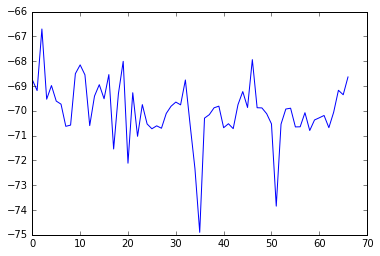

In [85]:
pl.figure()
pl.plot(bou_bns.baseH)

In [86]:
remove_outlier_baselines(bou_bns)

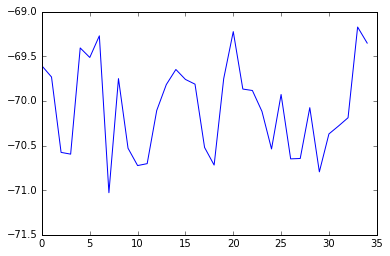

In [87]:
pl.figure()
pl.plot(bou_bns.baseH)

In [88]:
bou_abs_ords = get_ord_abs_from_baselines(bou_bns)

In [89]:
remove_outlier_baselines(bou_bns)

In [90]:
bou_abs_ords.ordp1

array([[ 20819.0225    ,  20822.6725    ,  20835.5725    ,  20830.505     ,
         20834.92      ,  20838.195     ,  20839.1875    ,  20841.3375    ,
         20842.5775    ,  20855.4525    ,  20856.925     ,  20853.8875    ,
         20831.53      ,  20832.8425    ,  20826.38      ,  20828.645     ,
         20843.1925    ,  20832.9675    ,  20837.4525    ,  20846.0975    ,
         20830.6325    ,  20834.1125    ,  20769.14      ,  20794.5625    ,
         20859.625     ,  20864.105     ,  20833.81      ,  20833.975     ,
         20839.245     ,  20840.4875    ,  20816.2625    ,  20812.6225    ,
         20812.0275    ,  20856.985     ,  20866.515     ],
       [   -66.05552143,    -69.56509653,    -69.58531975,    -70.39066131,
           -77.32957443,    -98.58777987,    -60.17731356,    -66.21031332,
           -73.53311902,   -101.7679456 ,    -99.69692926,   -103.47704148,
           -75.13988255,    -80.45152894,    -55.17681569,    -65.26578657,
          -111.69252708,    

In [91]:
Mbou, resbou, rankbou, sigbou = get_transform_from_abs_ords(bou_abs_ords)

In [92]:
Mbou

array([[  9.83427577e-01,  -1.54730742e-01,   2.73849863e-02,
         -1.27616468e+03],
       [  1.66801730e-01,   9.87916201e-01,  -4.98683323e-03,
         -8.45819258e-01],
       [ -6.72505308e-03,  -1.18093515e-02,   9.96186901e-01,
          9.05380089e+02],
       [ -0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [93]:
resbou

array([  8.12387327e+00,   6.62182726e+00,   2.38802764e+00,
         1.24385440e-37])

In [94]:
rankbou

4

In [95]:
m2 = np.dot(np.vstack([bou_abs_ords.ordp1,np.ones_like(bou_abs_ords.ordp1[0])]),np.vstack([bou_abs_ords.absp1,np.ones_like(bou_abs_ords.absp1[0])]).T)
m2

array([[  1.49668069e+10,   2.29654469e+09,   3.49755539e+10,
          7.29213470e+05],
       [ -6.45768758e+07,  -9.89864120e+06,  -1.50900417e+08,
         -3.14617119e+03],
       [  3.40342627e+10,   5.22230716e+09,   7.95338758e+10,
          1.65822030e+06],
       [  7.18360022e+05,   1.10227043e+05,   1.67871880e+06,
          3.50000000e+01]])

In [96]:
hezfbouJan16 = factory.get_timeseries(observatory='BOU',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

C:\Users\aclaycomb\AppData\Local\Continuum\Anaconda2\lib\site-packages\geomagio\edge\EdgeFactory.py:520: ObsPyDeprecationWarning: 'getWaveform' has been renamed to 'get_waveforms'. Use that instead.
  edge_channel, starttime, endtime)


In [97]:
bouJan16adj = make_adjusted_from_transform_and_raw(Mbou,hezfbouJan16)

In [98]:
bouJan16adj[1,1:5]

array([ 3127.49144074,  3131.6261902 ,  3135.43180642,  3137.51476505])

In [99]:
bouh_pqqm = np.mean(bou_abs_ords.absp1[0] - bou_abs_ords.ordp1[0])

boue_pqqm = np.mean(bou_abs_ords.absp1[1] - bou_abs_ords.ordp1[1])

bouz_pqqm = np.mean(bou_abs_ords.absp1[2] - bou_abs_ords.ordp1[2])

(-30, 30)

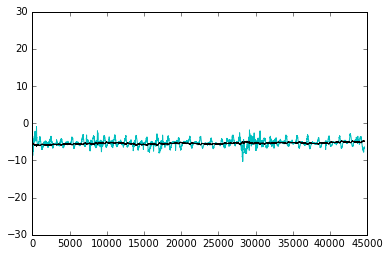

In [100]:
pl.figure()
pl.plot(((hezfbouJan16[0].data+bouh_pqqm)**2 + (hezfbouJan16[1].data+boue_pqqm)**2 + (hezfbouJan16[2].data+bouz_pqqm)**2)**(0.5) - hezfbouJan16[3].data + 23.1,'c')

pl.hold(True)

pl.plot((bouJan16adj[0]**2 + bouJan16adj[1]**2 + bouJan16adj[2]**2)**(0.5) - hezfbouJan16[3].data + 23.1,'k')

pl.ylim(-30,30)

In [101]:
save_state('/users/aclaycomb/Documents/adjbou_state_.json', Mbou, -22)

In [112]:
hezfbouJan16[0].stats.channel = 'H'
file1 = open('/users/aclaycomb/Documents/BOU201601vmin.min','w')
a = geomagio.iaga2002.IAGA2002Writer()
a.write(file1,hezfbouJan16,['H', 'E', 'Z', 'F'])
stats1 = hezfbouJan16[0].stats
stats1.channel
stats1.channel = 'X'
x = obspy.core.Trace(bouJan16adj[0], stats1)
stats1.channel = 'Y'
y = obspy.Trace(bouJan16adj[1], stats1)
stats1.channel = 'Z'
z = obspy.Trace(bouJan16adj[2], stats1)
stats1.channel = 'F'
f = obspy.Trace(hezfbouJan16[3].data - 22, stats1)
adjbouJan16 = obspy.Stream([x,y,z,f])
a = geomagio.iaga2002.IAGA2002Writer()

In [113]:
file2 = open('/users/aclaycomb/Documents/BOU201601adj.min', 'w')
a.write(file2,adjbouJan16,['X', 'Y', 'Z', 'F'])

In [115]:
brw_bns = get_baselines_from_file('/users/aclaycomb/Documents/brwjson12.txt')

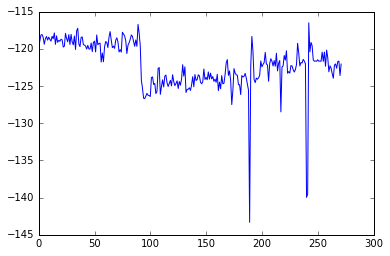

In [116]:
pl.plot(brw_bns.baseH)

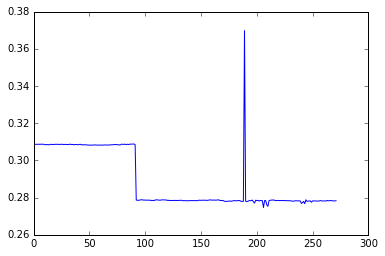

In [117]:
pl.plot(brw_bns.baseD)

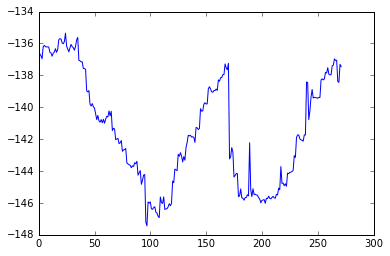

In [118]:
pl.plot(brw_bns.baseZ)

In [119]:
a = UTCDateTime(2015,7,1,0,0,0)

b = UTCDateTime(2015,9,1,0,0,0)

get_bns_between_dates(a,b,brw_bns)

In [120]:
remove_outlier_baselines(brw_bns)

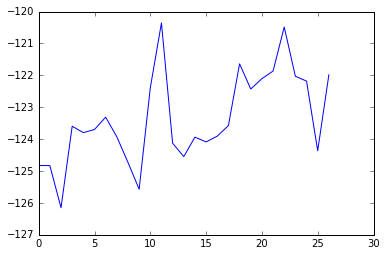

In [121]:
pl.plot(brw_bns.baseH)

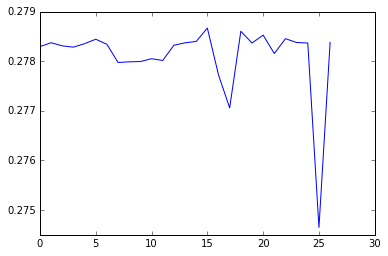

In [122]:
pl.plot(brw_bns.baseD)

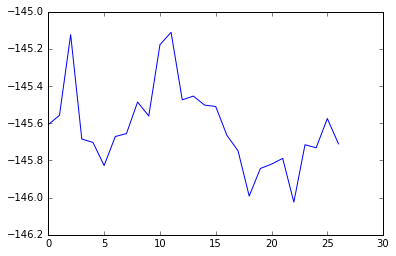

In [123]:
pl.plot(brw_bns.baseZ)

In [124]:
brw_abs_ord = get_ord_abs_from_baselines(brw_bns)

In [125]:
Mbrw, resbrw, rankbrw, sigbrw = get_transform_from_abs_ords(brw_abs_ord)

In [126]:
Mbrw

array([[  9.34857870e-01,  -3.26009140e-01,   1.26923853e-02,
         -6.01772088e+02],
       [  3.29840807e-01,   1.08450379e+00,  -4.38199362e-02,
          1.96667652e+03],
       [ -9.26036364e-04,  -5.46591946e-05,   9.98670684e-01,
         -6.15282786e+01],
       [  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [127]:
resbrw

array([  5.04178763e+01,   8.74894816e+02,   8.79660086e-01,
         1.34495954e-37])

In [128]:
rankbrw

4

In [129]:
sigbrw

array([  2.99444530e+05,   9.36118621e+02,   1.18394564e+02,
         2.08605176e-03])

In [130]:
hezfbrwJan16 = factory.get_timeseries(observatory='BRW',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-30T23:59:59Z'))

In [131]:
brwJan16adj = make_adjusted_from_transform_and_raw(Mbrw,hezfbrwJan16)

In [132]:
brwh_pqqm = np.mean(brw_abs_ord.absp1[0] - brw_abs_ord.ordp1[0])

brwe_pqqm = np.mean(brw_abs_ord.absp1[1] - brw_abs_ord.ordp1[1])

brwz_pqqm = np.mean(brw_abs_ord.absp1[2] - brw_abs_ord.ordp1[2])

(-30, 30)

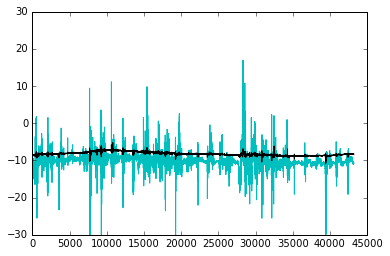

In [133]:
pl.plot(((hezfbrwJan16[0].data+brwh_pqqm)**2 + (hezfbrwJan16[1].data+brwe_pqqm)**2 + (hezfbrwJan16[2].data+brwz_pqqm)**2)**(0.5) - hezfbrwJan16[3].data + 1,'c')

pl.hold(True)

pl.plot((brwJan16adj[0]**2 + brwJan16adj[1]**2 + brwJan16adj[2]**2)**(0.5) - hezfbrwJan16[3].data + 1.0,'k')

pl.ylim(-30,30)

In [134]:
save_state('/users/aclaycomb/Documents/adjbrw_state_.json', Mbrw, -1)

In [135]:
cmo_bns = get_baselines_from_file('/users/aclaycomb/Documents/cmojson12.txt')

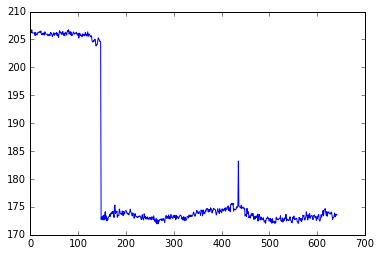

In [136]:
pl.plot(cmo_bns.baseH)

In [137]:
a = UTCDateTime(2015,7,1,0,0,0)

b = UTCDateTime(2015,9,1,0,0,0)

get_bns_between_dates(a,b,cmo_bns)

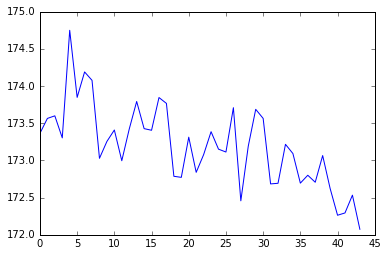

In [138]:
pl.plot(cmo_bns.baseH)

In [139]:
remove_outlier_baselines(cmo_bns)

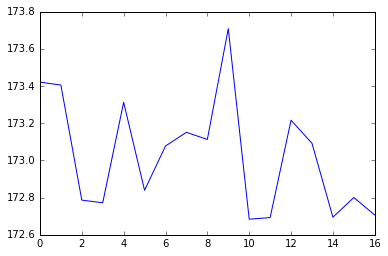

In [140]:
pl.plot(cmo_bns.baseH)

In [141]:
cmo_abs_ord = get_ord_abs_from_baselines(cmo_bns)

In [142]:
Mcmo, rescmo, rankcmo, sigcmo = get_transform_from_abs_ords(cmo_abs_ord)

In [143]:
Mcmo

array([[  9.39880017e-01,  -3.08098629e-01,   8.11979835e-03,
         -2.01433612e+02],
       [  3.22786162e-01,   9.68250360e-01,   1.65168860e-02,
         -8.65385130e+02],
       [ -6.29637516e-03,  -4.05108544e-03,   9.91887061e-01,
          4.72928486e+02],
       [  2.57918802e-15,  -3.27337577e-15,  -0.00000000e+00,
          1.00000000e+00]])

In [144]:
rescmo

array([  4.43079439e-01,   5.71490493e-01,   2.15290921e-01,
         2.83800382e-38])

In [145]:
rankcmo

4

In [146]:
sigcmo

array([  2.34191239e+05,   6.16124599e+01,   4.15099818e+01,
         6.83659777e-04])

In [147]:
hezfcmoJan16 = factory.get_timeseries(observatory='CMO',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [148]:
cmoJan16adj = make_adjusted_from_transform_and_raw(Mcmo,hezfcmoJan16)

In [149]:
cmoh_pqqm = np.mean(cmo_abs_ord.absp1[0] - cmo_abs_ord.ordp1[0])

cmoe_pqqm = np.mean(cmo_abs_ord.absp1[1] - cmo_abs_ord.ordp1[1])

cmoz_pqqm = np.mean(cmo_abs_ord.absp1[2] - cmo_abs_ord.ordp1[2])

(-30, 30)

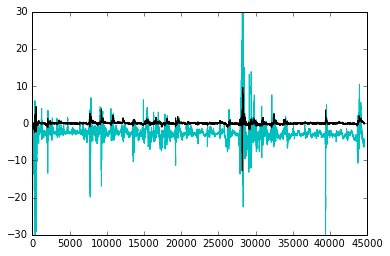

In [150]:
pl.plot(((hezfcmoJan16[0].data+cmoh_pqqm)**2 + (hezfcmoJan16[1].data+cmoe_pqqm)**2 + (hezfcmoJan16[2].data+cmoz_pqqm)**2)**(0.5) - hezfcmoJan16[3].data - 7.9,'c')

pl.hold(True)

pl.plot((cmoJan16adj[0]**2 + cmoJan16adj[1]**2 + cmoJan16adj[2]**2)**(0.5) - hezfcmoJan16[3].data - 7.9,'k')

pl.ylim(-30,30)

In [151]:
save_state('/users/aclaycomb/Documents/adjcmo_state_.json', Mcmo, 7.9)

In [152]:
frd_bns = get_baselines_from_file('/users/aclaycomb/Documents/frdjson12.txt')

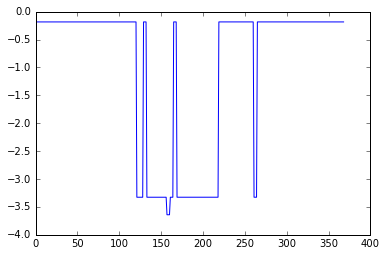

In [153]:
pl.plot(frd_bns.baseD)

In [154]:
a = UTCDateTime(2015,8,1,0,0,0)

b = UTCDateTime(2015,10,1,0,0,0)

get_bns_between_dates(a,b,frd_bns)

In [155]:
remove_outlier_baselines(frd_bns)

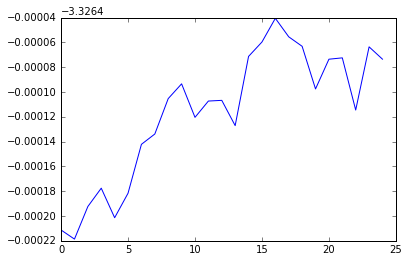

In [156]:
pl.plot(frd_bns.baseD)

In [157]:
frd_abs_ord = get_ord_abs_from_baselines(frd_bns)

In [158]:
Mfrd, resfrd, rankfrd, sigfrd = get_transform_from_abs_ords(frd_abs_ord)

In [159]:
Mfrd

array([[ -9.82142394e-01,  -1.83524785e-01,   1.28706175e-02,
         -5.26638206e+02],
       [  1.79292243e-01,  -1.00656618e+00,   1.13500368e-01,
         -5.12726686e+03],
       [  3.98204985e-03,   6.04692528e-03,   1.01122495e+00,
          9.93776528e+01],
       [  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [160]:
resfrd

array([  1.65574426e+00,   1.93399773e+01,   2.49780320e-01,
         4.92759318e-39])

In [161]:
rankfrd

4

In [162]:
sigfrd

array([  2.53434501e+05,   8.05438116e+01,   1.80397682e+01,
         5.10446006e-04])

In [163]:
hezffrdJan16 = factory.get_timeseries(observatory='FRD',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [164]:
frdJan16adj = make_adjusted_from_transform_and_raw(Mfrd,hezffrdJan16)

In [165]:
frdh_pqqm = np.mean(frd_abs_ord.absp1[0] - frd_abs_ord.ordp1[0])

frde_pqqm = np.mean(frd_abs_ord.absp1[1] - frd_abs_ord.ordp1[1])

frdz_pqqm = np.mean(frd_abs_ord.absp1[2] - frd_abs_ord.ordp1[2])

(-30, 30)

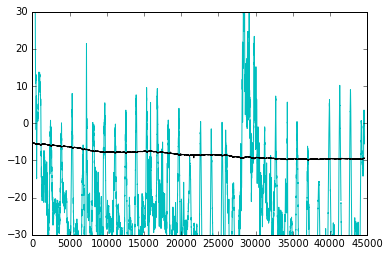

In [166]:
pl.plot(((hezffrdJan16[0].data+frdh_pqqm)**2 + (hezffrdJan16[1].data+frde_pqqm)**2 + (hezffrdJan16[2].data+frdz_pqqm)**2)**(0.5) - hezffrdJan16[3].data + 4.6,'c')

pl.hold(True)

pl.plot((frdJan16adj[0]**2 + frdJan16adj[1]**2 + frdJan16adj[2]**2)**(0.5) - hezffrdJan16[3].data + 4.6,'k')

pl.ylim(-30,30)

In [167]:
save_state('/users/aclaycomb/Documents/adjfrd_state_.json', Mfrd, -4.6)

In [168]:
frn_bns = get_baselines_from_file('/users/aclaycomb/Documents/frnjson12.txt')

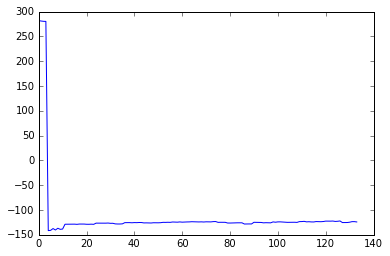

In [169]:
pl.plot(frn_bns.baseH)

In [170]:
a = UTCDateTime(2015,5,1,0,0,0)

b = UTCDateTime(2015,6,10,0,0,0)

get_bns_between_dates(a,b,frn_bns)

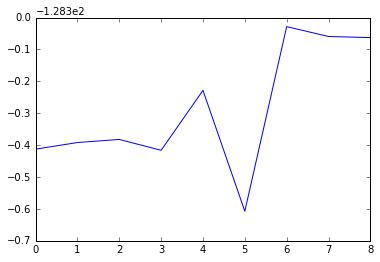

In [171]:
pl.plot(frn_bns.baseH)

In [172]:
frn_abs_ord = get_ord_abs_from_baselines(frn_bns)

In [173]:
Mfrn, resfrn, rankfrn, sigfrn = get_transform_from_abs_ords(frn_abs_ord)

In [174]:
Mfrn

array([[  9.68565555e-01,  -2.00310287e-01,  -2.76807061e-02,
          1.17417624e+03],
       [  2.42370058e-01,   1.02706749e+00,  -1.21082597e-01,
          4.70604971e+03],
       [ -2.33058122e-02,  -1.65549754e-02,   1.02128327e+00,
         -3.03542290e+02],
       [  0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [175]:
resfrn

array([  3.27533547e-02,   4.12836189e-01,   2.23735118e-02,
         1.61860062e-39])

In [176]:
rankfrn

4

In [177]:
sigfrn

array([  1.45113868e+05,   3.65063445e+01,   2.10145476e+01,
         1.23018540e-04])

In [178]:
hezffrnJan16 = factory.get_timeseries(observatory='FRN',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [179]:
frnJan16adj = make_adjusted_from_transform_and_raw(Mfrn,hezffrnJan16)

In [180]:
frnh_pqqm = np.mean(frn_abs_ord.absp1[0] - frn_abs_ord.ordp1[0])

frne_pqqm = np.mean(frn_abs_ord.absp1[1] - frn_abs_ord.ordp1[1])

frnz_pqqm = np.mean(frn_abs_ord.absp1[2] - frn_abs_ord.ordp1[2])

(-30, 30)

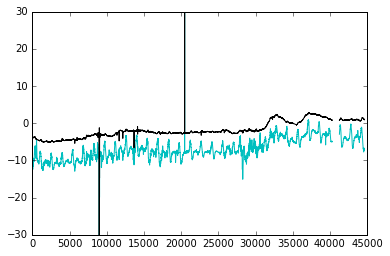

In [181]:
pl.plot(((hezffrnJan16[0].data+frnh_pqqm)**2 + (hezffrnJan16[1].data+frne_pqqm)**2 + (hezffrnJan16[2].data+frnz_pqqm)**2)**(0.5) - hezffrnJan16[3].data + 6,'c')

pl.hold(True)

pl.plot((frnJan16adj[0]**2 + frnJan16adj[1]**2 + frnJan16adj[2]**2)**(0.5) - hezffrnJan16[3].data + 6,'k')

pl.ylim(-30,30)

In [182]:
save_state('/users/aclaycomb/Documents/adjfrn_state_.json', Mfrn, -6)

In [183]:
gua_bns = get_baselines_from_file('/users/aclaycomb/Documents/guajson12.txt')

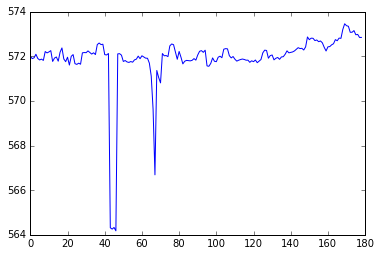

In [184]:
pl.plot(gua_bns.baseH)

In [185]:
a = UTCDateTime(2015,10,15,0,0,0)

b = UTCDateTime(2015,12,15,0,0,0)

get_bns_between_dates(a,b,gua_bns)

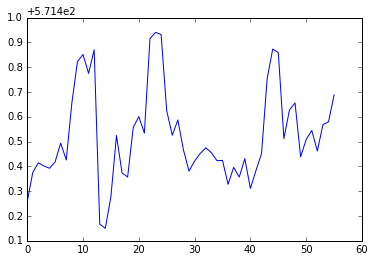

In [186]:
pl.plot(gua_bns.baseH)

In [187]:
remove_outlier_baselines(gua_bns)

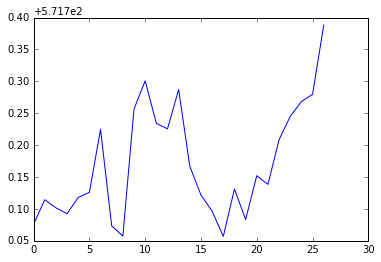

In [188]:
pl.plot(gua_bns.baseH)

In [189]:
gua_abs_ord = get_ord_abs_from_baselines(gua_bns)

In [190]:
Mgua, resgua, rankgua, siggua = get_transform_from_abs_ords(gua_abs_ord)

In [191]:
Mgua

array([[  9.98443843e-01,  -1.93733450e-02,  -4.25390474e-03,
          6.52567915e+02],
       [  2.02166513e-02,   1.00429017e+00,   7.01363090e-03,
         -6.73172625e+01],
       [  6.93024175e-04,  -4.44958958e-03,   1.00187292e+00,
          2.19933652e+02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [192]:
resgua

array([  1.38786609e-01,   8.45265521e+00,   1.15363688e+00,
         7.95410191e-37])

In [193]:
hezfguaJan16 = factory.get_timeseries(observatory='GUA',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [194]:
guaJan16adj = make_adjusted_from_transform_and_raw(Mgua,hezfguaJan16)

In [195]:
guah_pqqm = np.mean(gua_abs_ord.absp1[0] - gua_abs_ord.ordp1[0])

guae_pqqm = np.mean(gua_abs_ord.absp1[1] - gua_abs_ord.ordp1[1])

guaz_pqqm = np.mean(gua_abs_ord.absp1[2] - gua_abs_ord.ordp1[2])

(-10, 10)

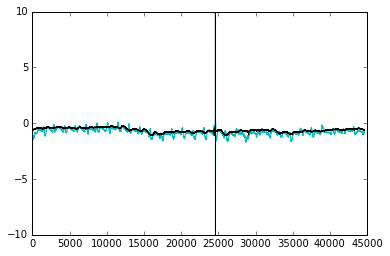

In [196]:
pl.plot(((hezfguaJan16[0].data+guah_pqqm)**2 + (hezfguaJan16[1].data+guae_pqqm)**2 + (hezfguaJan16[2].data+guaz_pqqm)**2)**(0.5) - hezfguaJan16[3].data - 7.9,'c')

pl.hold(True)

pl.plot((guaJan16adj[0]**2 + guaJan16adj[1]**2 + guaJan16adj[2]**2)**(0.5) - hezfguaJan16[3].data - 7.9,'k')

pl.ylim(-10,10)

In [197]:
save_state('/users/aclaycomb/Documents/adjgua_state_.json', Mgua, 7.9)

In [198]:
hon_bns = get_baselines_from_file('/users/aclaycomb/Documents/honjson12.txt')

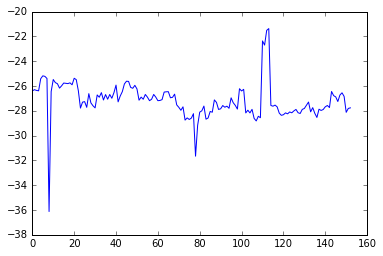

In [199]:
pl.plot(hon_bns.baseH)

In [200]:
a = UTCDateTime(2015,10,15,0,0,0)

b = UTCDateTime(2015,12,15,0,0,0)

get_bns_between_dates(a,b,hon_bns)

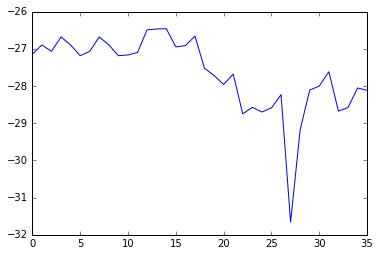

In [201]:
pl.plot(hon_bns.baseH)

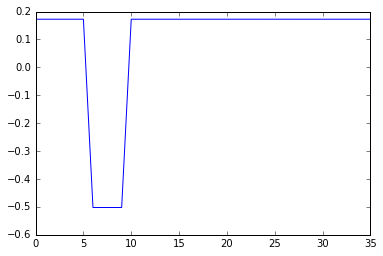

In [202]:
pl.plot(hon_bns.baseD)

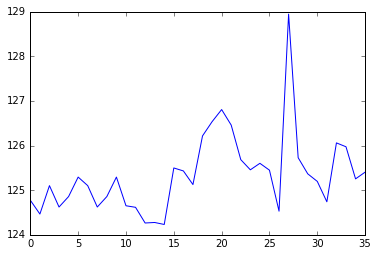

In [203]:
pl.plot(hon_bns.baseZ)

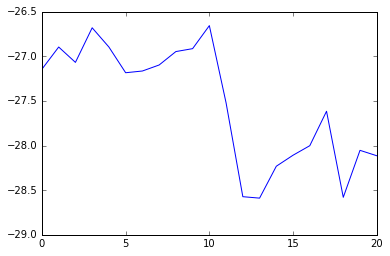

In [204]:
remove_outlier_baselines(hon_bns)

pl.plot(hon_bns.baseH)

In [205]:
hon_abs_ord = get_ord_abs_from_baselines(hon_bns)

In [206]:
Mhon, reshon, rankhon, sighon = get_transform_from_abs_ords(hon_abs_ord)

In [207]:
Mhon

array([[  9.99678600e-01,  -1.74029673e-01,   2.63717245e-02,
         -9.82568114e+02],
       [  1.69668389e-01,   1.01995732e+00,  -5.55170451e-03,
          1.74349733e+02],
       [  1.23732740e-03,  -1.69453292e-03,   1.05273966e+00,
         -1.02140068e+03],
       [  0.00000000e+00,   2.98072927e-15,  -1.09299776e-15,
          1.00000000e+00]])

In [208]:
reshon

array([  9.16388677e+00,   4.33161926e+00,   3.69640761e+00,
         4.59177481e-41])

In [209]:
hezfhonJan16 = factory.get_timeseries(observatory='HON',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [210]:
honJan16adj = make_adjusted_from_transform_and_raw(Mhon,hezfhonJan16)

In [211]:
honh_pqqm = np.mean(hon_abs_ord.absp1[0] - hon_abs_ord.ordp1[0])

hone_pqqm = np.mean(hon_abs_ord.absp1[1] - hon_abs_ord.ordp1[1])

honz_pqqm = np.mean(hon_abs_ord.absp1[2] - hon_abs_ord.ordp1[2])

(-30, 30)

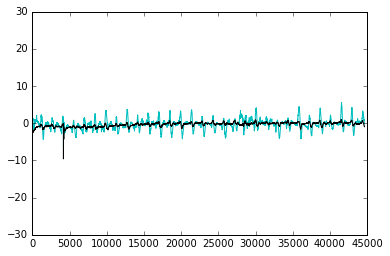

In [212]:
pl.plot(((hezfhonJan16[0].data+honh_pqqm)**2 + (hezfhonJan16[1].data+hone_pqqm)**2 + (hezfhonJan16[2].data+honz_pqqm)**2)**(0.5) - hezfhonJan16[3].data - 14.5,'c')

pl.hold(True)

pl.plot((honJan16adj[0]**2 + honJan16adj[1]**2 + honJan16adj[2]**2)**(0.5) - hezfhonJan16[3].data - 14.5,'k')

pl.ylim(-30,30)

In [213]:
save_state('/users/aclaycomb/Documents/adjhon_state_.json', Mhon, 14.5)

In [214]:
new_bns = get_baselines_from_file('/users/aclaycomb/Documents/newjson12.txt')

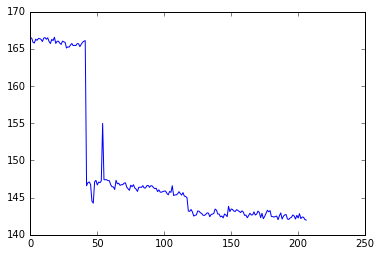

In [215]:
pl.plot(new_bns.baseH)

In [216]:
a = UTCDateTime(2015,10,15,0,0,0)

b = UTCDateTime(2015,12,15,0,0,0)

get_bns_between_dates(a,b,new_bns)

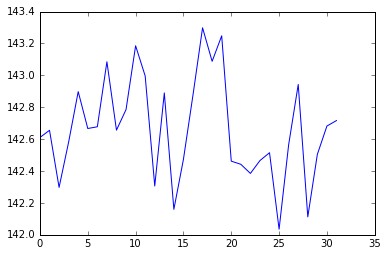

In [217]:
pl.plot(new_bns.baseH)

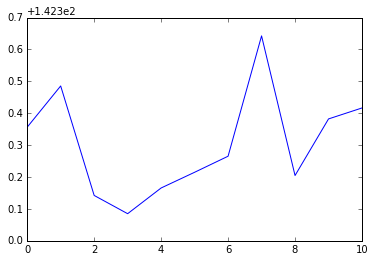

In [218]:
remove_outlier_baselines(new_bns)

pl.plot(new_bns.baseH)

In [219]:
new_abs_ord = get_ord_abs_from_baselines(new_bns)

In [220]:
Mnew, resnew, ranknew, signew = get_transform_from_abs_ords(new_abs_ord)

In [221]:
Mnew

array([[  9.70381886e-01,  -2.61357358e-01,  -5.88339193e-03,
          3.31498500e+02],
       [  2.78701300e-01,   9.69226963e-01,   4.60085193e-02,
         -2.56585110e+03],
       [ -1.91365970e-02,   6.40280253e-03,   9.26542509e-01,
          4.80701668e+03],
       [  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [222]:
resnew

array([  2.77548347e-02,   5.00419296e-01,   2.95001807e-01,
         1.51528569e-39])

In [223]:
hezfnewJan16 = factory.get_timeseries(observatory='NEW',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [224]:
newJan16adj = make_adjusted_from_transform_and_raw(Mnew,hezfnewJan16)

In [225]:
newh_pqqm = np.mean(new_abs_ord.absp1[0] - new_abs_ord.ordp1[0])

newe_pqqm = np.mean(new_abs_ord.absp1[1] - new_abs_ord.ordp1[1])

newz_pqqm = np.mean(new_abs_ord.absp1[2] - new_abs_ord.ordp1[2])

(-30, 30)

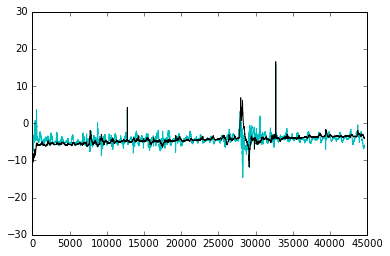

In [226]:
pl.plot(((hezfnewJan16[0].data+newh_pqqm)**2 + (hezfnewJan16[1].data+newe_pqqm)**2 + (hezfnewJan16[2].data+newz_pqqm)**2)**(0.5) - hezfnewJan16[3].data + 7.1,'c')

pl.hold(True)

pl.plot((newJan16adj[0]**2 + newJan16adj[1]**2 + newJan16adj[2]**2)**(0.5) - hezfnewJan16[3].data + 7.1,'k')

pl.ylim(-30,30)

In [227]:
save_state('/users/aclaycomb/Documents/adjnew_state_.json', Mnew, -7.1)

In [228]:
shu_bns = get_baselines_from_file('/users/aclaycomb/Documents/shujson12.txt')

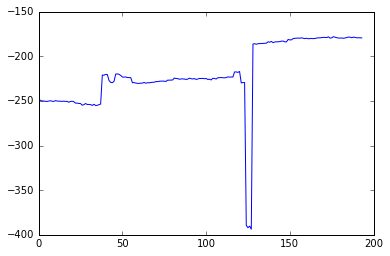

In [229]:
pl.plot(shu_bns.baseH)

In [230]:
a = UTCDateTime(2015,10,25,0,0,0)

b = UTCDateTime(2016,1,1,0,0,0)

get_bns_between_dates(a,b,shu_bns)

In [231]:
remove_outlier_baselines(shu_bns)

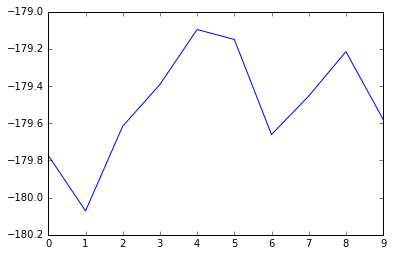

In [232]:
pl.plot(shu_bns.baseH)

In [233]:
shu_abs_ord = get_ord_abs_from_baselines(shu_bns)

In [234]:
Mshu, resshu, rankshu, sigshu = get_transform_from_abs_ords(shu_abs_ord)

In [235]:
Mshu

array([[  9.88588472e-01,  -2.08072460e-01,  -6.35567167e-03,
         -1.47139029e+01],
       [  2.10268162e-01,   9.69217999e-01,  -1.82802376e-02,
          5.17502020e+02],
       [  1.51436210e-02,   4.47899422e-03,   1.01739086e+00,
         -1.48503633e+03],
       [  1.99237003e-15,  -2.49062245e-15,  -0.00000000e+00,
          1.00000000e+00]])

In [236]:
resshu

array([  3.73523464e-01,   8.51217195e-01,   1.34919961e-01,
         1.48084738e-39])

In [237]:
hezfshuJan16 = factory.get_timeseries(observatory='SHU',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [238]:
shuJan16adj = make_adjusted_from_transform_and_raw(Mshu,hezfshuJan16)

In [239]:
shuh_pqqm = np.mean(shu_abs_ord.absp1[0] - shu_abs_ord.ordp1[0])

shue_pqqm = np.mean(shu_abs_ord.absp1[1] - shu_abs_ord.ordp1[1])

shuz_pqqm = np.mean(shu_abs_ord.absp1[2] - shu_abs_ord.ordp1[2])

(-30, 30)

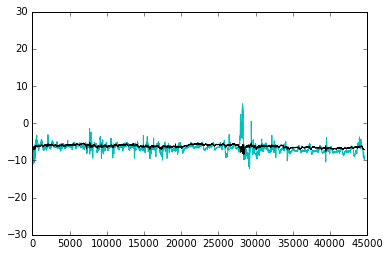

In [240]:
pl.plot(((hezfshuJan16[0].data+shuh_pqqm)**2 + (hezfshuJan16[1].data+shue_pqqm)**2 + (hezfshuJan16[2].data+shuz_pqqm)**2)**(0.5) - hezfshuJan16[3].data - 13.1,'c')

pl.hold(True)

pl.plot((shuJan16adj[0]**2 + shuJan16adj[1]**2 + shuJan16adj[2]**2)**(0.5) - hezfshuJan16[3].data - 13.1,'k')

pl.ylim(-30,30)

In [241]:
save_state('/users/aclaycomb/Documents/adjshu_state_.json', Mshu, 13.1)

In [242]:
sit_bns = get_baselines_from_file('/users/aclaycomb/Documents/sitjson12.txt')

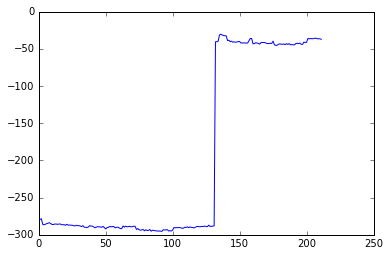

In [243]:
pl.plot(sit_bns.baseH)

In [244]:
a = UTCDateTime(2015,10,1,0,0,0)

b = UTCDateTime(2016,1,1,0,0,0)

get_bns_between_dates(a,b,sit_bns)

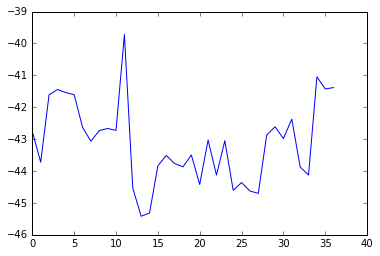

In [245]:
pl.plot(sit_bns.baseH)

In [246]:
remove_outlier_baselines(sit_bns)

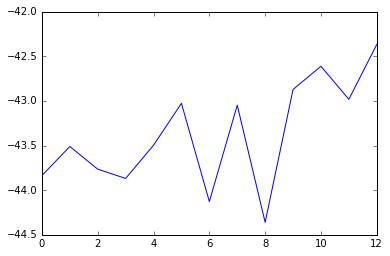

In [247]:
pl.plot(sit_bns.baseH)

In [248]:
sit_abs_ord = get_ord_abs_from_baselines(sit_bns)

In [249]:
Msit, ressit, ranksit, sigsit = get_transform_from_abs_ords(sit_abs_ord)

In [250]:
Msit

array([[  9.59545352e-01,  -3.66675295e-01,  -1.06533425e-01,
          5.29374275e+03],
       [  2.40650589e-01,   1.03242483e+00,  -2.66118481e-02,
          2.86265553e+03],
       [  2.24111073e-02,   2.01999547e-02,   1.00408997e+00,
          2.41162824e+02],
       [  1.08442241e-15,  -0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [251]:
ressit

array([  1.18381961e+00,   5.83420751e+00,   6.22840607e-01,
         1.57555273e-39])

In [252]:
hezfsitJan16 = factory.get_timeseries(observatory='SIT',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-30T23:59:59Z'))

In [253]:
sitJan16adj = make_adjusted_from_transform_and_raw(Msit,hezfsitJan16)

In [254]:
sith_pqqm = np.mean(sit_abs_ord.absp1[0] - sit_abs_ord.ordp1[0])

site_pqqm = np.mean(sit_abs_ord.absp1[1] - sit_abs_ord.ordp1[1])

sitz_pqqm = np.mean(sit_abs_ord.absp1[2] - sit_abs_ord.ordp1[2])

(-30, 30)

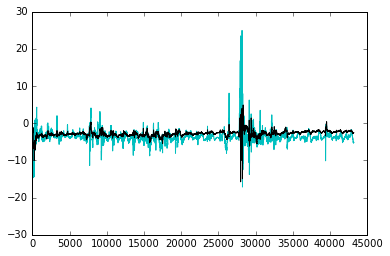

In [255]:
pl.plot(((hezfsitJan16[0].data+sith_pqqm)**2 + (hezfsitJan16[1].data+site_pqqm)**2 + (hezfsitJan16[2].data+sitz_pqqm)**2)**(0.5) - hezfsitJan16[3].data - 3.2,'c')

pl.hold(True)

pl.plot((sitJan16adj[0]**2 + sitJan16adj[1]**2 + sitJan16adj[2]**2)**(0.5) - hezfsitJan16[3].data - 3.2,'k')

pl.ylim(-30,30)

In [256]:
save_state('/users/aclaycomb/Documents/adjsit_state_.json', Msit, 3.2)

In [257]:
sjg_bns = get_baselines_from_file('/users/aclaycomb/Documents/sjgjson12.txt')

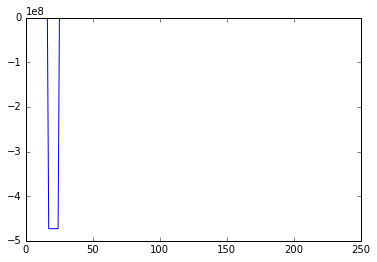

In [258]:
pl.plot(sjg_bns.baseH)

In [259]:
a = UTCDateTime(2015,10,1,0,0,0)

b = UTCDateTime(2015,12,1,0,0,0)

get_bns_between_dates(a,b,sjg_bns)

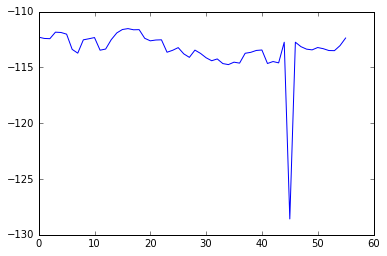

In [260]:
pl.plot(sjg_bns.baseH)

In [261]:
remove_outlier_baselines(sjg_bns)

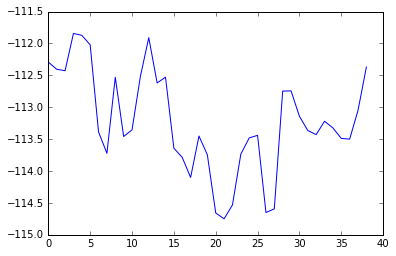

In [262]:
pl.plot(sjg_bns.baseH)

In [263]:
sjg_abs_ord = get_ord_abs_from_baselines(sjg_bns)

In [264]:
Msjg, ressjg, ranksjg, sigsjg = get_transform_from_abs_ords(sjg_abs_ord)

In [265]:
Msjg

array([[  9.90536307e-01,   2.04242590e-01,   3.87150502e-02,
         -1.50422264e+03],
       [ -2.27532793e-01,   9.62960561e-01,   5.14425894e-03,
          8.62310605e+01],
       [ -6.93279286e-03,   2.77582644e-02,   9.44616720e-01,
          1.70847335e+03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [266]:
ressjg

array([  1.76264961e+01,   7.71329740e+00,   1.34822012e+01,
         3.73081703e-39])

In [267]:
hezfsjgJan16 = factory.get_timeseries(observatory='SJG',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [268]:
sjgJan16adj = make_adjusted_from_transform_and_raw(Msjg,hezfsjgJan16)

In [269]:
sjgh_pqqm = np.mean(sjg_abs_ord.absp1[0] - sjg_abs_ord.ordp1[0])

sjge_pqqm = np.mean(sjg_abs_ord.absp1[1] - sjg_abs_ord.ordp1[1])

sjgz_pqqm = np.mean(sjg_abs_ord.absp1[2] - sjg_abs_ord.ordp1[2])

(-30, 30)

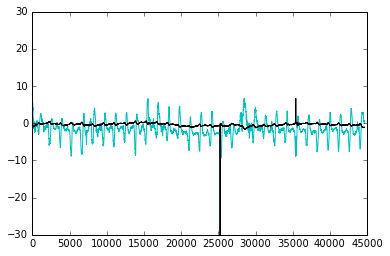

In [270]:
pl.plot(((hezfsjgJan16[0].data+sjgh_pqqm)**2 + (hezfsjgJan16[1].data+sjge_pqqm)**2 + (hezfsjgJan16[2].data+sjgz_pqqm)**2)**(0.5) - hezfsjgJan16[3].data + 55,'c')

pl.hold(True)

pl.plot((sjgJan16adj[0]**2 + sjgJan16adj[1]**2 + sjgJan16adj[2]**2)**(0.5) - hezfsjgJan16[3].data + 55,'k')

pl.ylim(-30,30)

In [271]:
save_state('/users/aclaycomb/Documents/adjsjg_state_.json', Msjg, -55)

In [272]:
bsl_bns = get_baselines_from_file('/users/aclaycomb/Documents/bsljson12.txt')

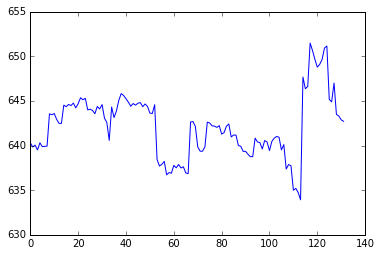

In [273]:
pl.plot(bsl_bns.baseH)

In [274]:
a = UTCDateTime(2015,10,1,0,0,0)

b = UTCDateTime(2016,1,1,0,0,0)

get_bns_between_dates(a,b,bsl_bns)

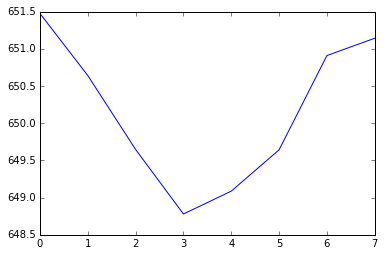

In [275]:
pl.plot(bsl_bns.baseH)

In [276]:
bsl_abs_ord = get_ord_abs_from_baselines(bsl_bns)

In [277]:
Mbsl, resbsl, rankbsl, sigbsl = get_transform_from_abs_ords(bsl_abs_ord)

In [278]:
Mbsl

array([[  1.05069413e+00,   1.10714328e-01,  -2.11533688e-01,
          8.16799353e+03],
       [  2.79831733e-02,   1.06881857e+00,  -1.29195735e-01,
          4.37112281e+03],
       [ -3.85811324e-02,  -5.23226381e-02,   1.12178759e+00,
         -4.01891646e+03],
       [  0.00000000e+00,  -0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]])

In [279]:
resbsl

array([  2.28382379e+00,   2.91445223e+00,   7.70382134e-01,
         3.85709084e-39])

In [280]:
hezfbslJan16 = factory.get_timeseries(observatory='BSL',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [281]:
bslJan16adj = make_adjusted_from_transform_and_raw(Mbsl,hezfbslJan16)

In [282]:
bslh_pqqm = np.mean(bsl_abs_ord.absp1[0] - bsl_abs_ord.ordp1[0])

bsle_pqqm = np.mean(bsl_abs_ord.absp1[1] - bsl_abs_ord.ordp1[1])

bslz_pqqm = np.mean(bsl_abs_ord.absp1[2] - bsl_abs_ord.ordp1[2])

(-10, 10)

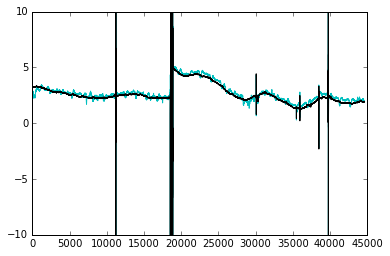

In [283]:
pl.plot(((hezfbslJan16[0].data+bslh_pqqm)**2 + (hezfbslJan16[1].data+bsle_pqqm)**2 + (hezfbslJan16[2].data+bslz_pqqm)**2)**(0.5) - hezfbslJan16[3].data + 4.2,'c')

pl.hold(True)

pl.plot((bslJan16adj[0]**2 + bslJan16adj[1]**2 + bslJan16adj[2]**2)**(0.5) - hezfbslJan16[3].data + 4.2,'k')

pl.ylim(-10,10)

In [284]:
save_state('/users/aclaycomb/Documents/adjbsl_state_.json', Mbsl, -4.2)

In [285]:
tuc_bns = get_baselines_from_file('/users/aclaycomb/Documents/tucjson12.txt')

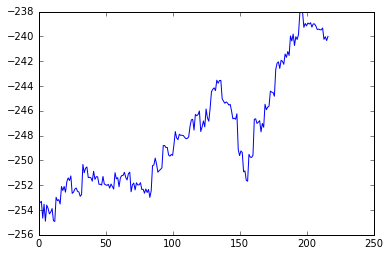

In [286]:
pl.plot(tuc_bns.baseH)

In [287]:
a = UTCDateTime(2015,12,1,0,0,0)

b = UTCDateTime(2016,1,1,0,0,0)

get_bns_between_dates(a,b,tuc_bns)

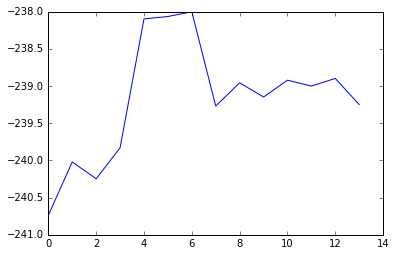

In [288]:
pl.plot(tuc_bns.baseH)

In [289]:
tuc_abs_ord = get_ord_abs_from_baselines(tuc_bns)

In [290]:
Mtuc, restuc, ranktuc, sigtuc = get_transform_from_abs_ords(tuc_abs_ord)

In [291]:
Mtuc

array([[  9.83650649e-01,  -2.14063605e-01,   8.68640018e-02,
         -3.67288828e+03],
       [  2.12187743e-01,   8.89843829e-01,   2.22513804e-01,
         -1.02132303e+04],
       [ -1.15735139e-02,   3.83529111e-02,   8.93747080e-01,
          4.91693773e+03],
       [  0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
          1.00000000e+00]])

In [292]:
restuc

array([  9.16746608e-01,   2.68686591e+00,   4.59761366e-01,
         1.91204373e-39])

In [293]:
hezftucJan16 = factory.get_timeseries(observatory='TUC',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [294]:
tucJan16adj = make_adjusted_from_transform_and_raw(Mtuc,hezftucJan16)

In [295]:
tuch_pqqm = np.mean(tuc_abs_ord.absp1[0] - tuc_abs_ord.ordp1[0])

tuce_pqqm = np.mean(tuc_abs_ord.absp1[1] - tuc_abs_ord.ordp1[1])

tucz_pqqm = np.mean(tuc_abs_ord.absp1[2] - tuc_abs_ord.ordp1[2])

(-30, 30)

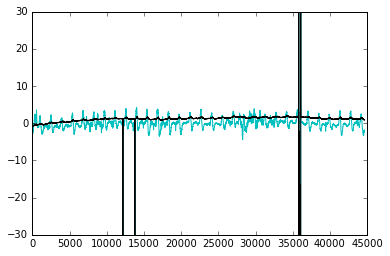

In [296]:
pl.plot(((hezftucJan16[0].data+tuch_pqqm)**2 + (hezftucJan16[1].data+tuce_pqqm)**2 + (hezftucJan16[2].data+tucz_pqqm)**2)**(0.5) - hezftucJan16[3].data + 4.7,'c')

pl.hold(True)

pl.plot((tucJan16adj[0]**2 + tucJan16adj[1]**2 + tucJan16adj[2]**2)**(0.5) - hezftucJan16[3].data + 4.7,'k')

pl.ylim(-30,30)

In [297]:
save_state('/users/aclaycomb/Documents/adjtuc_state_.json', Mtuc, -4.7)

In [298]:
np.pi/2

1.5707963267948966

In [299]:
ded_bh = np.array([-137.8, -137.7, -140.1, -139.2, -138.2, -140.5, -138.4, -139.4, -137.4, -138.7])

In [300]:
ded_bd = np.pi/180/60*np.array([1265.5, 1266.3, 1265.7, 1265.6, 1266.3, 1265.7, 1265.1, 1265.1, 1265.9, 1265.8])

In [301]:
ded_bz = np.array([22.4, 22.6, 22.8, 22.5, 22.7, 23.1, 22.6, 23.1, 23.0, 22.7])

In [302]:
ded_ah = np.array([8931.4, 8922.9, 8970.2, 8880.4, 8992.0, 9038.4, 8943.7, 8985.0, 8944.5, 8960.9])

In [303]:
ded_ad = np.pi/180/60*np.array([1121.7, 1127.8, 1121.7, 1143.9, 1128.7, 1130.9, 1132.0, 1123.5, 1127.0, 1119.4])

In [304]:
ded_az = np.array([56850.0, 56825.0, 56840.4, 56834.9, 56856.0, 56816.0, 56832.4, 56831.0, 56809.0, 56834.3])

In [305]:
ded_bns = Baselines()

In [306]:
ded_bns.baseH = ded_bh

ded_bns.baseD = ded_bd

ded_bns.baseZ = ded_bz

ded_bns.absH = ded_ah

ded_bns.absD = ded_ad

ded_bns.absZ = ded_az

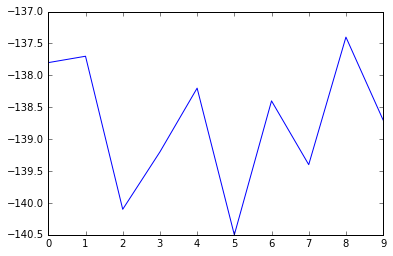

In [307]:
pl.plot(ded_bns.baseH)

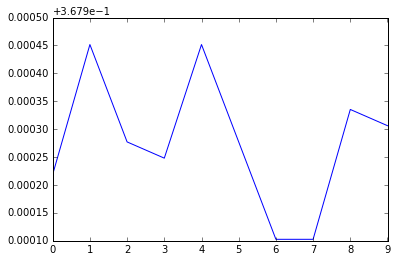

In [308]:
pl.plot(ded_bns.baseD)

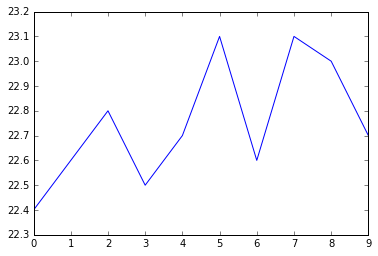

In [309]:
pl.plot(ded_bns.baseZ)

In [310]:
ded_abs_ord = get_ord_abs_from_baselines(ded_bns)

In [311]:
Mded, resded, rankded, sigded = get_transform_from_abs_ords(ded_abs_ord)

In [312]:
Mded

array([[  9.17300296e-01,  -3.73211099e-01,  -5.14226627e-03,
          2.98482986e+02],
       [  3.53096520e-01,   9.06733279e-01,   6.61541037e-04,
         -2.98943984e+01],
       [  3.68482513e-03,  -3.82402473e-04,   9.90805880e-01,
          5.11440783e+02],
       [  0.00000000e+00,   1.61017236e-15,  -0.00000000e+00,
          1.00000000e+00]])

In [313]:
resded

array([  4.44991815e+00,   1.17540091e+01,   1.07493093e-01,
         1.63926361e-38])

In [314]:
hezfdedJan16 = factory.get_timeseries(observatory='DED',

        interval='minute',

        type='variation',

        channels=('H', 'E', 'Z', 'F'),

        starttime=UTCDateTime('2016-01-01T00:00:00Z'),

        endtime=UTCDateTime('2016-01-31T23:59:59Z'))

In [315]:
dedJan16adj = make_adjusted_from_transform_and_raw(Mded,hezfdedJan16)

In [316]:
dedh_pqqm = np.mean(ded_abs_ord.absp1[0] - ded_abs_ord.ordp1[0])

dede_pqqm = np.mean(ded_abs_ord.absp1[1] - ded_abs_ord.ordp1[1])

dedz_pqqm = np.mean(ded_abs_ord.absp1[2] - ded_abs_ord.ordp1[2])

(-30, 30)

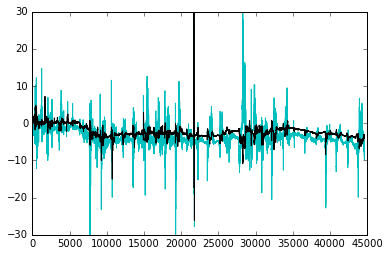

In [317]:
pl.plot(((hezfdedJan16[0].data+dedh_pqqm)**2 + (hezfdedJan16[1].data+dede_pqqm)**2 + (hezfdedJan16[2].data+dedz_pqqm)**2)**(0.5) - hezfdedJan16[3].data + 0.5,'c')

pl.hold(True)

pl.plot((dedJan16adj[0]**2 + dedJan16adj[1]**2 + dedJan16adj[2]**2)**(0.5) - hezfdedJan16[3].data + 0.5,'k')

pl.ylim(-30,30)

In [318]:
save_state('/users/aclaycomb/Documents/adjded_state_.json', Mded, -0.5)